### BANK CUSTOMERS CHURN CLASSIFICATION USING MLP (TF-KERAS)

#### Definition du problème
La compétition féroce exerce une pression sur le revenu des entreprises. Dans le secteur de la finance, les banques assistent à une réduction de dépôts des clients. Dans le but d’augmenter leurs actifs, les institutions financières adoptent une stratégie d’offre de taux d’intérêt attractifs. Pour cela, des campagnes ciblées de marketing sont mises en place avec une sélection rigoureuse des contacts ce qui permet une réduction des coûts et du temps. L’efficacité de ces campagnes de marketing ciblées peut être améliorée grâce à des méthodes de Deep learning.

Nous sommes une équipe de data scientiste qui a reçu mandat d’une banque pour construire un modèle de classification qui permettra d’augmenter considérablement l’efficacité des campagnes marketing. il permettra notamment d’identifier les caractéristiques principales qui affectent le succès d’un contact, c’est-à-dire prédire correctement si le contact a souscrit à l’offre de dépôt à terme faite par la banque. Dans le future la banque ciblera uniquement les clients qui presentent ces caracteristiques, favorisant une meilleure gestion des ressources financières et humaines.

#### Données
Le jeu de donnees original est disponible ici:https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

#### Evaluation
Nous souhaitons obtenir un modèle qui prédit correctement les TP c’est-à-dire classe correctement les contacts qui ont souscrit à l'offre de depôt. D’un autre côté, nous souhaitons obtenir un minimum les FN c’est-à-dire les contacts qui ont souscris mais le model les a classés comme n’ayant pas souscrit. La principale mesure d’évaluation sera le f1 score car in prend en considération le score de précision et le score de rappel. $$ F1 = 2*((precision*recall) / (precision+recall))$$

In [162]:
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
import seaborn as sn
import itertools

In [2]:
sns.set(rc={'figure.figsize':(10,5)})
pd.options.display.max_columns = None
pd.options.display.max_rows = None
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline
tf.random.set_seed(24)
from keras.callbacks import TensorBoard
from time import strftime
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from IPython.core.display import display
from time import strftime
from tensorflow.keras.layers import SimpleRNN

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
path = r'D:/DataBases/bank-additional/bank-additional/'
bankDataOr = pd.read_csv(path + 'bank-additional-full.csv', sep=';')
bankData = bankDataOr.copy()
print(bankData.shape)
bankData.head()

(41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


# 1. ANALYSE EXPLORATIVE DES DONNEES (EDA)

Nous allons proceder a une analyse de la forme et du fond des données

- **Variable cible** : y
- **Nombre de lignes et de colonnes** : 41188, 21 respectivement
- **Types de donnees** : Mixte (variables discrètes et continues)
- **Analyse des valeurs manquantes** : 00 

In [172]:
#pour afficher les valeurs manquantes
bankData.isnull().sum().sum()

0

In [155]:
#pour avoir une idee du type de donnees que contient chaque colonnes
bankData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [156]:
bankData.dtypes.value_counts()

object     11
int64       5
float64     5
dtype: int64

Le jeux de donnes contient: 
- 11 variables categorielles

- 10 variables continues

In [157]:
#Afficher le nom des collonnes contenaNt les variables categorielles
for label, content in bankData.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

job
marital
education
default
housing
loan
contact
month
day_of_week
poutcome
y


In [5]:
#on crée un sous ensemble de données avec uniquement les variables continues
categorical = ['job', 'marital', 
                'education', 'default', 
                'housing', 'loan', 
                'contact', 'month', 
                'day_of_week', 'poutcome']

In [158]:
#afficher le nom des colonnes contenant des valeurs numeriques
for label, content in bankData.items():
    if pd.api.types.is_integer_dtype(content) | pd.api.types.is_float_dtype(content):
        print(label)

age
duration
campaign
pdays
previous
emp.var.rate
cons.price.idx
cons.conf.idx
euribor3m
nr.employed


In [6]:
numerical = ['age', 'duration', 
             'campaign', 'pdays', 
             'previous', 'emp.var.rate', 
             'cons.price.idx', 'cons.conf.idx', 
             'euribor3m', 'nr.employed']

In [159]:
#on affiche chaques variables avec le nombres de valeurs uniques
for i in bankData.columns:
    print(bankData[i].value_counts(), sep = '\n')
    print('-'*40)

31    1947
32    1846
33    1833
36    1780
35    1759
34    1745
30    1714
37    1475
29    1453
39    1432
38    1407
41    1278
40    1161
42    1142
45    1103
43    1055
46    1030
44    1011
28    1001
48     979
47     928
50     875
27     851
49     839
52     779
51     754
53     733
56     704
26     698
54     684
55     648
57     646
25     598
58     576
24     463
59     463
60     283
23     226
22     137
21     102
61      73
20      65
62      62
64      57
66      57
63      55
71      53
70      47
65      44
19      42
76      34
73      34
72      34
69      34
68      33
74      32
80      31
18      28
78      27
67      26
75      24
88      22
77      20
81      20
83      17
82      17
85      15
79      14
86       8
84       7
17       5
92       4
98       2
89       2
91       2
94       1
87       1
95       1
Name: age, dtype: int64
----------------------------------------
admin.           10422
blue-collar       9254
technician        6743
services

Observations:
- Les variables `marital`, `job`, `education`, `housing`, `loan` ont toutes une modalitée `unknown` cela est surement dû à un soucis de confidentialité des contacts.   

no     89.0
yes    11.0
Name: y, dtype: float64


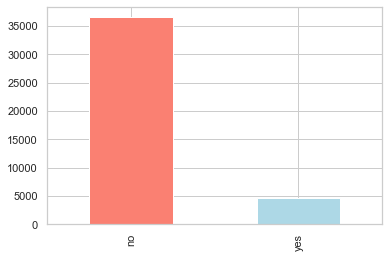

In [8]:
sns.set_style('whitegrid')
print(round(bankData["y"].value_counts(normalize=True)*100))
bankData["y"].value_counts().plot(kind="bar", color=["salmon", "lightblue"]);

- La repartition des classes de la variable cible est desequilibreé, la classe `no` est surrepresenteé par rapport à `yes` avec un ratio d'environ 89% et 11% respectivement.

**Analyse relation variables discrétes / variable cible `y`** 

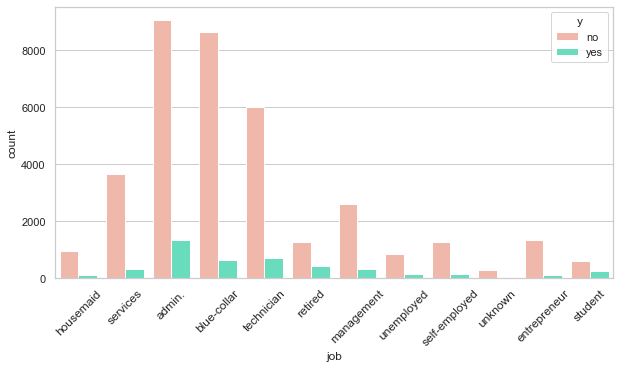

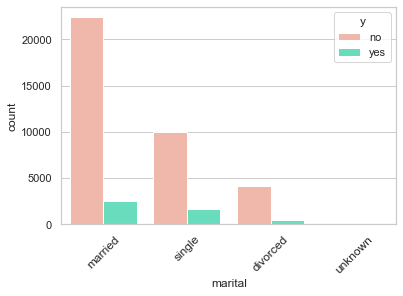

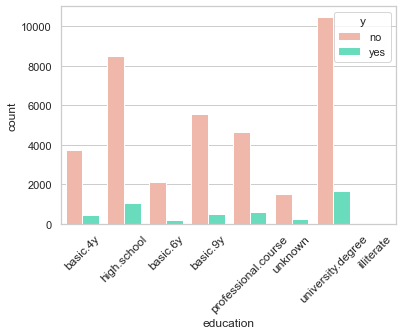

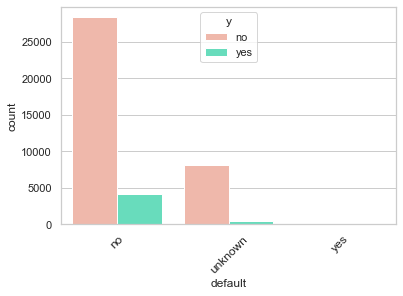

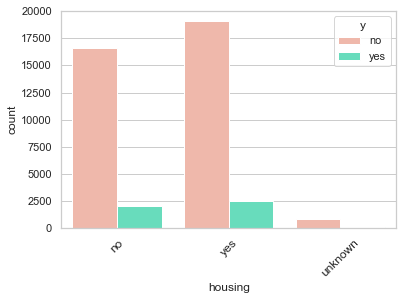

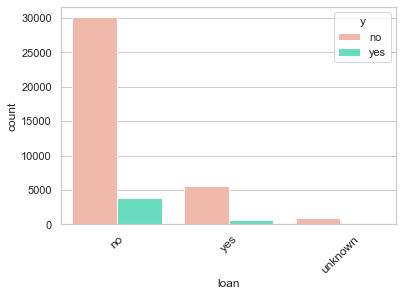

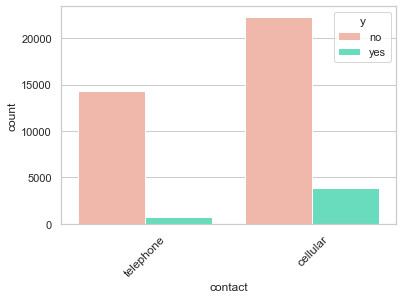

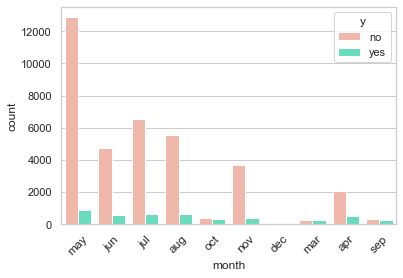

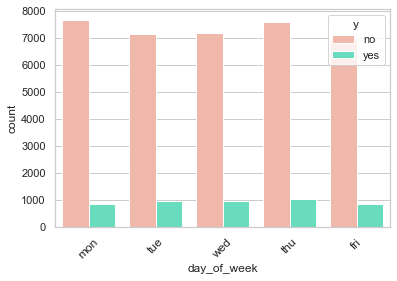

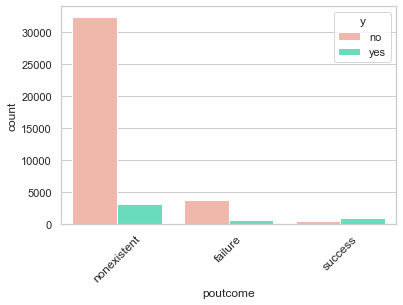

In [163]:
plt.figure(figsize=(10, 5))
for i in categorical:
    splot = sn.countplot(x = i, data = bankData , hue = 'y', palette= ['#fab1a0', '#55efc4'])
    plt.xticks(rotation = 45, size = 12)
    plt.show()

Observations:
- La majeure partie des `admin`, `blue-collar` et  `technician` n'a pas souscrit
- La majoritée des Personnes mariées n'a pas souscrit
- Les contact avec des defauts de paiement en general n'ont pas souscrit
- En generale les personnes avec des prets immobiliers en cours n'ont pas souscrit
- En generale les personnes qui ont un credit personnel en cours n'ont pas souscrit

**Analyse des contacts positifs uniquement**

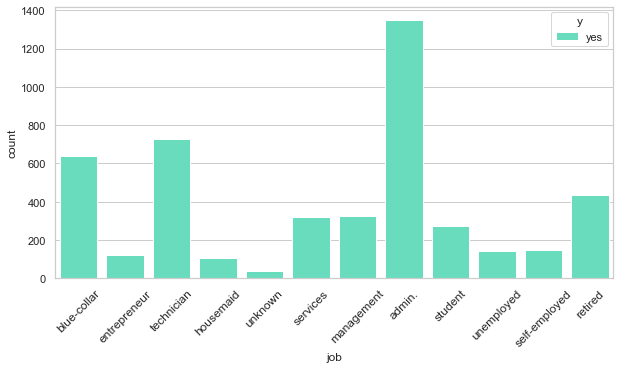

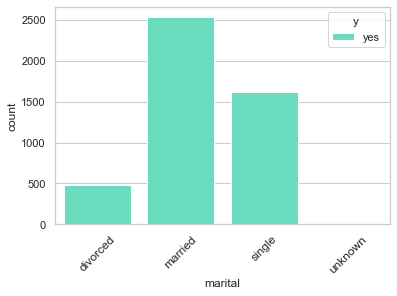

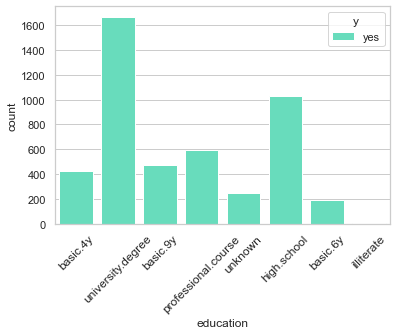

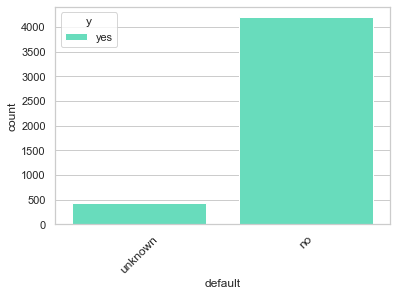

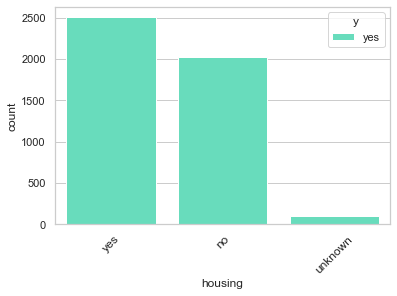

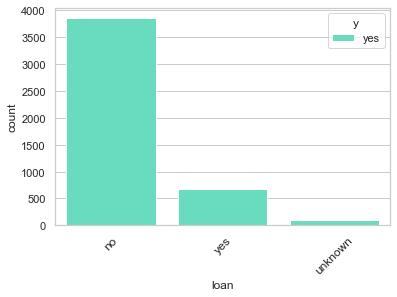

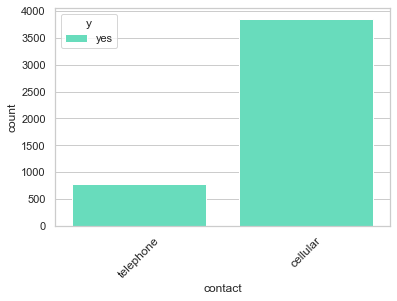

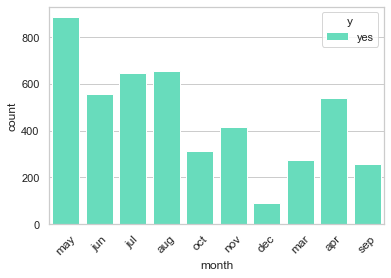

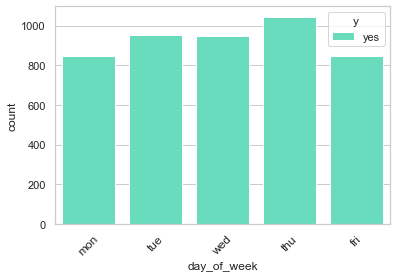

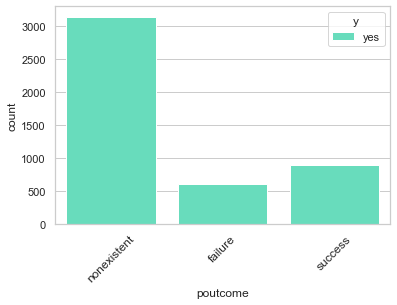

In [164]:
#contacts positif `yes` uniquement et leurs attribus
plt.figure(figsize=(10, 5))
for i in categorical:
    splot = sn.countplot(x = i, data = bankData[bankData['y'] == 'yes'] , hue = 'y', palette= ['#55efc4'])
    plt.xticks(rotation = 45, size = 12)
    plt.show()

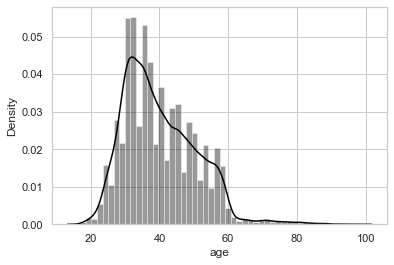

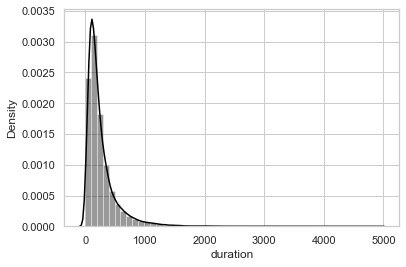

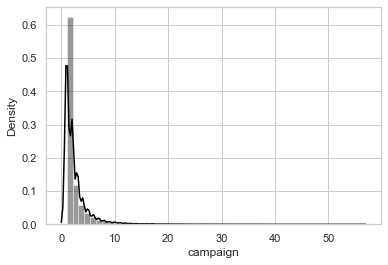

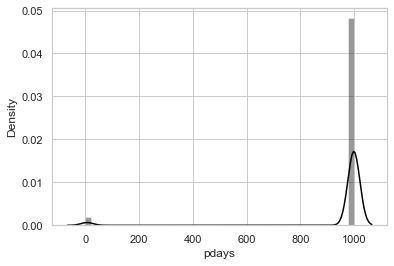

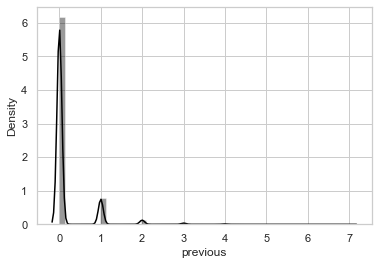

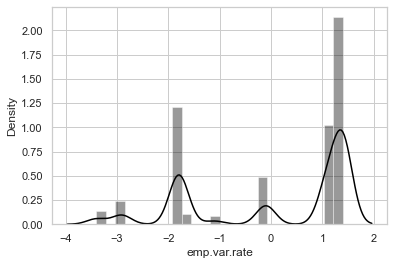

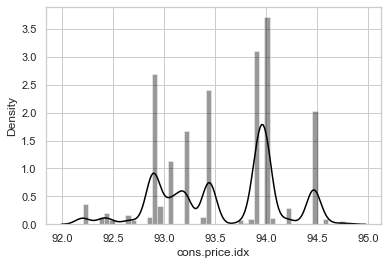

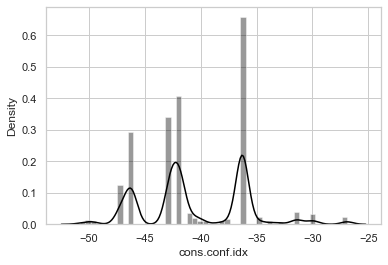

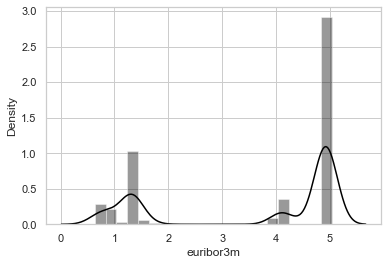

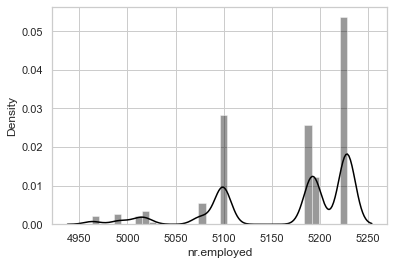

In [165]:
#visualisation de la distribution des variables numeriques
for col in bankData.select_dtypes(['int', 'float']):
    plt.figure()
    sn.distplot(bankData[col], color='black', hist=True)

- L'âge des contacts parait normalement distribué autour de la moyenne 40.
- La distribution de la durée `duration` est assymetrique
- Celle du nombre de contacts atteint par campagne `campaign` aussi est assymetrique

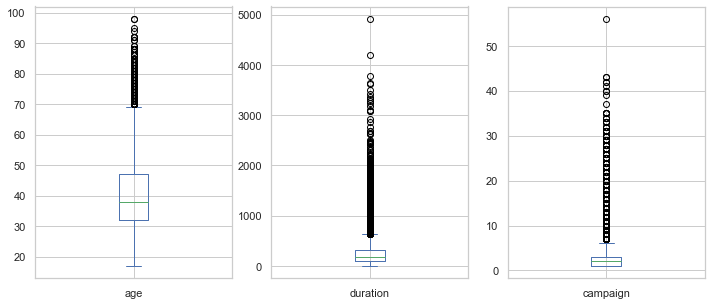

In [166]:
#on trace des boxplots pour detecter les outliers
bankData[['age', 'duration', 'campaign']].plot(kind= 'box', subplots=True, figsize=(12, 5));

Observations:
- Les variables `age`, `duration` et `campaign` presenteent des outliers.

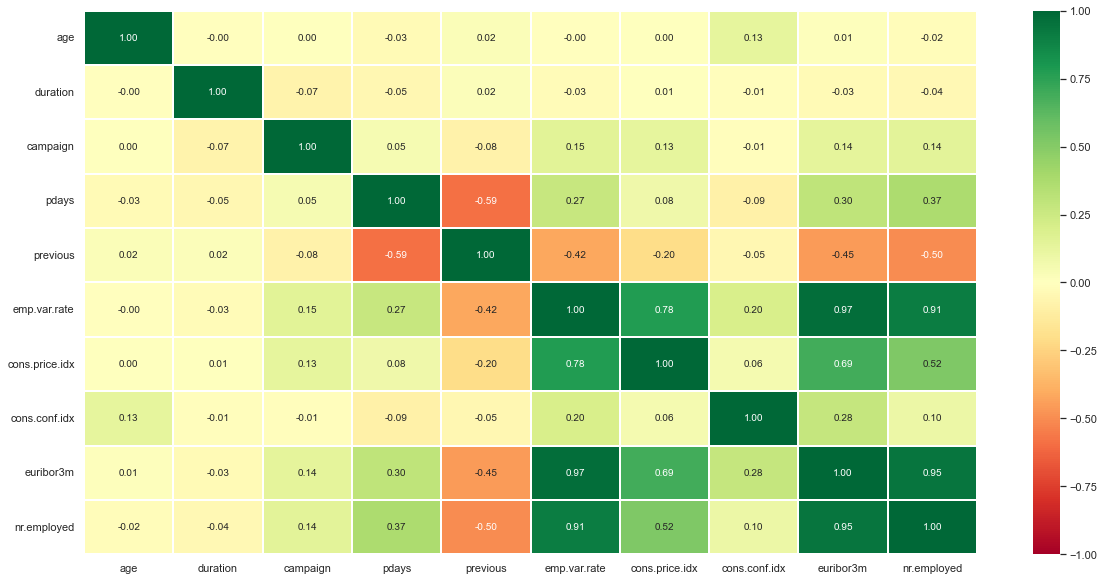

In [168]:
#Correlation entre les variables continues
corr = bankData[numerical].corr()
plt.figure(figsize =(20,10))
sn.heatmap(corr,
           vmin =-1,
           vmax = 1,
           annot = True,
           cbar = True,
           cmap = "RdYlGn",
           linewidths = 0.10,
           fmt = ".2f");

In [169]:
#Fonction pour détecter les fortes correlation entre les variables
CorField = []
for i in corr:
    for j in corr.index[corr[i] > 0.65]:
        if i != j and j not in CorField and i not in CorField:
            CorField.append(j)
            print ('Le coeff de correlation entre', i, 'et', j, 'est de:', corr[i][corr.index == j].values[0])

Le coeff de correlation entre emp.var.rate et cons.price.idx est de: 0.7753341708348431
Le coeff de correlation entre emp.var.rate et euribor3m est de: 0.9722446711516167
Le coeff de correlation entre emp.var.rate et nr.employed est de: 0.9069701012560616


Oservations:
- Tres forte correlation positive entre le nbre d'empoyés `nr.employed` et le taux d'interêt `euribor3m`.
- Aussi entre le taux le taux d'inflation `emp.var.rate` et et le taux de variation de taux d'emplois `cons.price.index`. 

In [171]:
#faire une copy du jeu de donnees definie bankDataPrep
bankDataPrep = bankData.copy()

## 2. Data preprocessing

### 2.1 Feature engineering

In [10]:
bankDataPrep['education'].value_counts()

university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64

La variable `education` contient 8 modalitées dont 3 qui ont un même prefix `basic`: Nous pouvons regrouper ces 3 modalitées en 

une seule appelée `middle.school` et ainsi reduire la dimensionalitée de notre jeux de données.

In [11]:
lst=['basic.9y','basic.6y','basic.4y']
for i in lst:
    bankDataPrep.loc[bankDataPrep['education'] == i, 'education'] = "middle.school"

In [12]:
#on verifie le resultat
bankDataPrep['education'].value_counts()

middle.school          12513
university.degree      12168
high.school             9515
professional.course     5243
unknown                 1731
illiterate                18
Name: education, dtype: int64

### 2.2. Encodage de la variable `pdays`

`999` signifie que le contact n'a jamais été contacté pour une camapgne precedente, nous pouvons substituer `999` par `0`.

In [13]:
bankDataPrep.loc[bankDataPrep['pdays']== 999, 'pdays']= 0

### 2.2.3 Encodage de la variable cible `y` en remplaçant `yes` et `no` par `1`et `0` respectivement

In [15]:
#one-hot encoding targets Y
dict= {'yes':1,'no':0}
bankDataPrep['y']= bankDataPrep['y'].map(dict)

### 2.2.4  Normalisation les variables continues

In [173]:
#on separe la variable cible des variables ptredictives
X_bankDataPrep = bankDataPrep.iloc[:,:-1]
y_bankDataPrep = bankDataPrep.iloc[:,-1]

In [17]:
stdScaler = StandardScaler() #on crée une instance de la fonction de normalisation
stdScaler.fit(X_bankDataPrep[numerical])
scaled_X_bankDataPrep = stdScaler.transform(X_bankDataPrep[numerical])

In [18]:
#pour transformer une array contenant les variables continues normalisées en df
scaled_X_bankDataPrep = pd.DataFrame(scaled_X_bankDataPrep, columns=numerical)

In [19]:
#verification
scaled_X_bankDataPrep.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,1.533034,0.010471,-0.565922,-0.164012,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168
1,1.628993,-0.421501,-0.565922,-0.164012,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168
2,-0.290186,-0.124520,-0.565922,-0.164012,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168
3,-0.002309,-0.413787,-0.565922,-0.164012,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168
4,1.533034,0.187888,-0.565922,-0.164012,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168


In [20]:
bankDataPrep.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,middle.school,no,no,no,telephone,may,mon,261,1,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,middle.school,no,no,no,telephone,may,mon,151,1,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


In [21]:
print(X_bankDataPrep.shape)
print(y_bankDataPrep.shape)

(41188, 20)
(41188,)


### 2.2.5 One-Hot Encoding

In [22]:
#on transforme toutes les autres variables categoriques en variable numeriques de la forme 0:1
X_bankDataPrep_ohe = pd.get_dummies(X_bankDataPrep[X_bankDataPrep[categorical].columns], drop_first=False) 

In [23]:
print(X_bankDataPrep_ohe.shape)

(41188, 51)


In [24]:
X_bankDataPrep_ohe.head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_high.school,education_illiterate,education_middle.school,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
2,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0


In [25]:
#join all scaled X variables with all one-hoot encoded categorical variables
scaled_X_bankDataPrep_ohe = pd.concat([scaled_X_bankDataPrep, X_bankDataPrep_ohe], axis=1, ignore_index= False)

In [26]:
scaled_X_bankDataPrep_ohe.shape

(41188, 61)

In [27]:
#join the scaled, one-hot encoded and the y target variable
scaled_Xy_bankDataPrep_ohe = pd.concat([scaled_X_bankDataPrep_ohe, y_bankDataPrep], axis=1, ignore_index= False)

In [28]:
scaled_Xy_bankDataPrep_ohe.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_high.school,education_illiterate,education_middle.school,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,y
0,1.533034,0.010471,-0.565922,-0.164012,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
1,1.628993,-0.421501,-0.565922,-0.164012,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
2,-0.290186,-0.124520,-0.565922,-0.164012,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
3,-0.002309,-0.413787,-0.565922,-0.164012,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
4,1.533034,0.187888,-0.565922,-0.164012,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0


**Division des données en ensembles d' entrainement et de test proportion 90/10**

In [29]:
#on divise le jeu de donnees en 90% train et 10 test
train_inputs_all, test_inputs, train_targets_all, test_targets= train_test_split(scaled_Xy_bankDataPrep_ohe.iloc[:, :-1], 
                                                                         scaled_Xy_bankDataPrep_ohe.iloc[:,-1], train_size = 0.9, test_size=0.1, 
                                                                         stratify=scaled_Xy_bankDataPrep_ohe.y, random_state=24)

In [30]:
print(train_inputs_all.shape)
print(test_inputs.shape)
print(train_targets_all.shape)
print(test_targets.shape)

(37069, 61)
(4119, 61)
(37069,)
(4119,)


In [31]:
#### Constante pour le jeu de validation
val_size =  round(0.12*train_inputs_all.shape[0])

**Division des données d' entrainement en train et validation**

In [32]:
val_inputs = train_inputs_all[:val_size]
val_targets = train_targets_all[:val_size]

In [33]:
train_inputs = train_inputs_all[val_size:]
train_targets = train_targets_all[val_size:]

In [34]:
#pour verifier la dimension
print(train_inputs.shape)
print(train_targets.shape)
print(val_inputs.shape)
print(val_targets.shape)
print(test_inputs.shape)
print(test_targets.shape)

(32621, 61)
(32621,)
(4448, 61)
(4448,)
(4119, 61)
(4119,)


In [42]:
#pour exporter les données pretraités en csv
path = r"D:/Deep-Learning/bank-cc-prep-data/"

# train_inputs.to_csv(path + "train_inputs.csv", index=True, header=True)
# train_targets.to_csv(path + "train_targets.csv", index=True, header=True)
# val_inputs.to_csv(path + "val_inputs.csv", index=True, header=True)
# val_targets.to_csv(path + "val_targets.csv", index=True, header=True)
# test_inputs.to_csv(path + "test_inputs.csv", index=True, header=True)
# test_targets.to_csv(path + "test_targets.csv", index=True, header=True)

In [78]:
#pour charger les donées csv
train_inputs = pd.read_csv(path + "train_inputs.csv",  index_col=0)
train_targets = pd.read_csv(path + "train_targets.csv", index_col=0)
val_inputs = pd.read_csv(path + "val_inputs.csv", index_col=0)
val_targets = pd.read_csv(path + "val_targets.csv", index_col=0)
test_inputs = pd.read_csv(path + "test_inputs.csv", index_col=0)
test_targets = pd.read_csv(path + "test_targets.csv", index_col=0)

In [79]:
#pour retirer la colonne contenat les indexes
train_inputs = train_inputs.iloc[:,1:]
train_targets = train_targets.iloc[:,1]
val_inputs = val_inputs.iloc[:,1:]
val_targets = val_targets.iloc[:,1]
test_inputs = test_inputs.iloc[:,1:]
test_targets = test_targets.iloc[:,1]

**Definir les constantes utiles pour la modelisation**

In [103]:
Nber_classes = 2
Input_size = train_inputs.shape[1]
Logging_path = r"D:/Deep-Learning/bank-cust-churn_logs/"
alpha=0.001
output_size = 1 #Nber_classes
batch_size = 1000
max_epochs = 100
prev_validation_loss = 9999999.

### One-Hot Encoding  variables Cibles

In [99]:
train_targets_ohe = tf.keras.utils.to_categorical(train_targets, Nber_classes)
val_targets_ohe =  tf.keras.utils.to_categorical(val_targets, Nber_classes)
test_targets_ohe = tf.keras.utils.to_categorical(test_targets, Nber_classes)

### 3. Modelisation

#### 3.1 Multi layer Perceptron avec Tensorflow

In [104]:
n_hidden_1= 250
n_hidden_2= 50
n_hidden_3= 50

In [82]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

In [105]:
#where we feed the data
#definir les place-holder
inputs = tf.placeholder(tf.float32, [None, Input_size], name= "Features")
targets = tf.placeholder(tf.float32, [None, Nber_classes], name= "Labels")

##### 1st Hidden Layer

In [106]:
with tf.name_scope("Hidden_layer_1"):
    initial_weights_1 = tf.random.truncated_normal(shape=[Input_size, n_hidden_1], stddev=0.1, seed=24)
    weights_1 = tf.Variable(initial_value=initial_weights_1, name="w1")


    initial_biases_1 = tf.constant(value=0.0, shape=[n_hidden_1])
    biases_1 = tf.Variable(initial_value=initial_biases_1, name="b1")

    #input 1st layer
    layer1_in = tf.matmul(inputs, weights_1) + biases_1
    #output 1st layer
    layer1_out = tf.nn.relu(layer1_in)

##### 2nd Hidden Layer

In [107]:
with tf.name_scope("Hidden_layer_2"):
    initial_weights_2 = tf.random.truncated_normal(shape=[n_hidden_1, n_hidden_2], stddev=0.1, seed=24)
    weights_2 = tf.Variable(initial_value=initial_weights_2, name="w2")

    initial_biases_2 = tf.constant(value=0.0, shape=[n_hidden_2])
    biases_2 = tf.Variable(initial_value=initial_biases_2, name="b2")

    #input 2nd layer
    layer2_in = tf.matmul(layer1_out, weights_2) + biases_2
    #output 2nd layer
    layer2_out = tf.nn.relu(layer2_in)

##### 3rd Hidden Layer

In [108]:
with tf.name_scope("Hidden_layer_3"):
    initial_weights_3 = tf.random.truncated_normal(shape=[n_hidden_2, n_hidden_3], stddev=0.1, seed=24)
    weights_3 = tf.Variable(initial_value=initial_weights_3, name="w3")

    initial_biases_3 = tf.constant(value=0.0, shape=[n_hidden_3])
    biases_3 = tf.Variable(initial_value=initial_biases_3, name="b3")

    #input 3rd layer
    layer3_in = tf.matmul(layer2_out, weights_3) + biases_3
    #output 3rd layer
    layer3_out = tf.nn.relu(layer3_in)

##### Output Layer 

In [109]:
with tf.name_scope("output_layer"):
    initial_weights_4= tf.random.truncated_normal(shape=[n_hidden_3, Nber_classes], stddev=0.1, seed=24)
    weights_4=tf.Variable(initial_value=initial_weights_4, name="w4")

    initial_biases_4= tf.constant(value=0.0, shape=[Nber_classes])
    biases_4=tf.Variable(initial_value=initial_biases_4, name="b4")
    
    #input 3rd layer
    layer4_in = tf.matmul(layer3_out, weights_4) + biases_4
    #output 3rd layer
    outputs = tf.nn.sigmoid(layer4_in)

##### Tensorboard

In [110]:
import os
folder_name = f'bank-churn on {strftime("%Y%m%d")} at {strftime("%H-%M-%p")}'
directory = os.path.join(Logging_path, folder_name)
try:
    os.makedirs(directory)
    
except OSError as exception:
    
    print(exception.strerror)
    
else:
    print("Directory successfully created!")

Directory successfully created!


##### Loss Function

In [111]:
#loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=targets, logits=outputs))
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=targets, logits=outputs))

In [112]:
optimizer = tf.train.AdamOptimizer(learning_rate=alpha)
train_step = optimizer.minimize(loss)

##### Evaluation Metrics

In [113]:
#index of prediction with highest prob
correct_preds = tf.equal(tf.argmax(outputs, axis=1), tf.argmax(targets, axis=1))
accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32))

In [114]:
tf.summary.scalar("Accuracy", accuracy)
tf.summary.scalar("Cost", loss)

<tf.Tensor 'Cost:0' shape=() dtype=string>

##### Session

In [115]:
sess= tf.InteractiveSession()

###### Set-Up Writers

In [116]:
merged_summary = tf.summary.merge_all()

train_writer = tf.summary.FileWriter(directory  + "/train")
train_writer.add_graph(sess.graph)
validation_writer = tf.summary.FileWriter(directory  + "/validation")
test_writer = tf.summary.FileWriter(directory  + "/test")

##### Init Var

In [117]:
initializer=tf.global_variables_initializer()
sess.run(initializer)

##### Batching

In [118]:
Nber_epochs = 100
batch_size = 1000
Nber_examples = train_inputs.shape[0]
Nber_iter = int(train_inputs.shape[0]/batch_size)
index_in_epochs = 0

In [119]:
def next_batch(batch_size, data, labels):
    
    global Nber_examples
    global index_in_epochs
    
    start = index_in_epochs
    index_in_epochs += batch_size
    
    if index_in_epochs > Nber_examples:
        start = 0
        index_in_epochs = batch_size
    
    end = index_in_epochs
    
    return data[start:end], labels[start:end]  

In [120]:
%%time
for epoch in range(Nber_epochs):
    #===========Training=================
    for i in range(Nber_iter):
        batch_x, batch_y = next_batch(batch_size=batch_size, data=train_inputs, labels=train_targets_ohe)
        feed_dict ={inputs:batch_x, targets:batch_y}
        sess.run(train_step, feed_dict)
        
    summary, batch_loss, batch_acc = sess.run(fetches=[merged_summary, loss, accuracy], feed_dict=feed_dict)
    train_writer.add_summary(summary, epoch)
    #===========Validation==============
    summary = sess.run(fetches=merged_summary, feed_dict={inputs:val_inputs, targets:val_targets_ohe})
    validation_writer.add_summary(summary, epoch)
    
    print(f"Epoch{epoch}:" + "  Training Loss:" + "{0:.4f}".format(batch_loss) + "  Training Accuracy:" + "{0:.4f}".format(batch_acc))
print("Done Training the Neural Network!")

Epoch0:  Training Loss:0.5577  Training Accuracy:0.8910
Epoch1:  Training Loss:0.5534  Training Accuracy:0.8910
Epoch2:  Training Loss:0.5483  Training Accuracy:0.9080
Epoch3:  Training Loss:0.5442  Training Accuracy:0.9140
Epoch4:  Training Loss:0.5429  Training Accuracy:0.9180
Epoch5:  Training Loss:0.5424  Training Accuracy:0.9140
Epoch6:  Training Loss:0.5420  Training Accuracy:0.9160
Epoch7:  Training Loss:0.5418  Training Accuracy:0.9160
Epoch8:  Training Loss:0.5415  Training Accuracy:0.9140
Epoch9:  Training Loss:0.5412  Training Accuracy:0.9140
Epoch10:  Training Loss:0.5410  Training Accuracy:0.9150
Epoch11:  Training Loss:0.5407  Training Accuracy:0.9160
Epoch12:  Training Loss:0.5404  Training Accuracy:0.9180
Epoch13:  Training Loss:0.5403  Training Accuracy:0.9200
Epoch14:  Training Loss:0.5401  Training Accuracy:0.9210
Epoch15:  Training Loss:0.5399  Training Accuracy:0.9230
Epoch16:  Training Loss:0.5397  Training Accuracy:0.9250
Epoch17:  Training Loss:0.5394  Training 

In [130]:
preds = sess.run(fetches=correct_preds, feed_dict={inputs:test_inputs, targets:test_targets_ohe})
preds[0:10]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

##### TEST

In [122]:
#==========Test=====================
test_accuracy = sess.run(fetches=accuracy, feed_dict={inputs:test_inputs, targets:test_targets_ohe})
print(f'Accuracy on test set is {test_accuracy:0.2%}')

Accuracy on test set is 90.60%


In [102]:
train_writer.close()
validation_writer.close()
sess.close()
tf.reset_default_graph()

#### 3.2 Multi Layer Perceptron avec keras

In [80]:
#premier model avec 3 couches cachées. fonction d'activation Relu pour les couches cachées et sigmoid pour la couche de sortie, 
#optimiseur adam et fonction coût binary_crossentropy pour classification binaire
NN_1 = Sequential([
    Dense(units=250, input_dim=Input_size, activation="relu", name="nn_hidden1"),
    Dense(units=50, activation="relu", name="nn_hidden2"),
    Dense(50, activation="relu", name="nn_hidden3"),
    Dense(1, activation="sigmoid", name="nn_output")
])
#2 optimizer, lost function and metric
NN_1.compile(optimizer="adam", 
             loss="binary_crossentropy", 
             metrics=["accuracy"])

In [81]:
NN_1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
nn_hidden1 (Dense)           (None, 250)               15500     
_________________________________________________________________
nn_hidden2 (Dense)           (None, 50)                12550     
_________________________________________________________________
nn_hidden3 (Dense)           (None, 50)                2550      
_________________________________________________________________
nn_output (Dense)            (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [133]:
#2nd model avec 3 couches cachées. fonction d'activation Relu pour les couches cachées et sigmoid pour la couche de sortie, 
#optimiseur adam et fonction coût binary_crossentropy pour classification binaire et dropout de 20% avant la premiere couche cachée
NN_2 = Sequential()
NN_2.add(Dropout(0.2, seed=24, input_shape=(Input_size,)))
NN_2.add(Dense(units=250, activation="relu", name="nn_2_hidden1"))
NN_2.add(Dense(units=50, activation="relu", name="nn_2_hidden2"))
NN_2.add(Dense(units=50, activation="relu", name="nn_2_hidden3"))
NN_2.add(Dense(units=1, activation="sigmoid", name="nn_2_output"))

#2 optimizer, loss function and metric
NN_2.compile(optimizer="adam", 
             loss="binary_crossentropy", 
             metrics=["accuracy"])

In [134]:
NN_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 61)                0         
_________________________________________________________________
nn_2_hidden1 (Dense)         (None, 250)               15500     
_________________________________________________________________
nn_2_hidden2 (Dense)         (None, 50)                12550     
_________________________________________________________________
nn_2_hidden3 (Dense)         (None, 50)                2550      
_________________________________________________________________
nn_2_output (Dense)          (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [135]:
#3rd model avec 3 couches cachées. fonction d'activation Relu pour les couches cachées et sigmoid pour la couche de sortie, 
#optimiseur adam et fonction coût binary_crossentropy pour classification binaire et dropout de 20% avant la premiere couche cachée
#dropout de 25% entre la premiere et la seconde couche cachée.
NN_3 = Sequential()
NN_3.add(Dropout(0.2, seed=24, input_shape=(Input_size,)))
NN_3.add(Dense(units=250, activation="relu", name="nn_3_hidden1"))
NN_3.add(Dropout(0.25, seed=24))
NN_3.add(Dense(units=50, activation="relu", name="nn_3_hidden2"))
NN_3.add(Dense(units=50, activation="relu", name="nn_3_hidden3"))
NN_3.add(Dense(units=1, activation="softmax", name="nn_3_output"))


NN_3.compile(optimizer="adam", 
             loss="binary_crossentropy", 
             metrics=["accuracy"])

In [136]:
NN_3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_1 (Dropout)          (None, 61)                0         
_________________________________________________________________
nn_3_hidden1 (Dense)         (None, 250)               15500     
_________________________________________________________________
dropout_2 (Dropout)          (None, 250)               0         
_________________________________________________________________
nn_3_hidden2 (Dense)         (None, 50)                12550     
_________________________________________________________________
nn_3_hidden3 (Dense)         (None, 50)                2550      
_________________________________________________________________
nn_3_output (Dense)          (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
__________________________________________________

In [141]:
LOG_DIR = r"D:/Deep-Learning/bank-cust-churn-keras_logs/"

In [140]:
#fonction pour monitorer le processus d'entrainnement avec tensorboard
import os
def get_tensorboard(model_name):

    folder_name = f'{model_name} at {strftime("%d %m %y %H %M")}'
    #print(folder_name)
    dir_paths = os.path.join(LOG_DIR, folder_name)

    try:
        os.makedirs(dir_paths)
    except OSError as err:
        print(err.strerror)
    else:
        print("Directory successfully created")

    return TensorBoard(log_dir = dir_paths)

In [138]:
samples_per_batchs = 1000
nber_epochs = 100

#nber_iters=X_train/batch size
#if nber_iters =2.It takes 2 iterrations to complete a single epoch 
#nber_iters=nber of batches to complete a single epochs
#n=33000, 
#batch_size=1000 i.e. the data set will be divided into batches 33, each with 1000 samples
#The model weights will be updated after each batch of 1000 samples.i.e. that 1 epoch will involve 
#33 batches or 33 updates to the model.
#With 100 epochs, the model will be exposed to or pass through the whole dataset 100 times. 
#That is a total of 33*100=3300 batches during the entire training process.

In [63]:
print(train_inputs.shape)
print(train_targets.shape)

(32621, 61)
(32621,)


In [73]:
type(train_targets)

pandas.core.series.Series

In [82]:
%%time
NN_1.fit(np.array(train_inputs), np.array(train_targets), 
         batch_size= samples_per_batchs, 
         epochs=nber_epochs,
         callbacks=[get_tensorboard("Bank-churn_1")], validation_data=(val_inputs, val_targets), verbose=1);

Directory successfully created
Train on 32621 samples, validate on 4448 samples
Epoch 1/100
32621/32621 [==============================] - 0s 10us/sample - loss: 0.3992 - acc: 0.8429 - val_loss: 0.2375 - val_acc: 0.8986
Epoch 2/100
32621/32621 [==============================] - 0s 8us/sample - loss: 0.2128 - acc: 0.9047 - val_loss: 0.1881 - val_acc: 0.9125
Epoch 3/100
32621/32621 [==============================] - 0s 7us/sample - loss: 0.1890 - acc: 0.9123 - val_loss: 0.1842 - val_acc: 0.9098
Epoch 4/100
32621/32621 [==============================] - 0s 7us/sample - loss: 0.1845 - acc: 0.9139 - val_loss: 0.1831 - val_acc: 0.9114
Epoch 5/100
32621/32621 [==============================] - 0s 8us/sample - loss: 0.1820 - acc: 0.9148 - val_loss: 0.1824 - val_acc: 0.9123
Epoch 6/100
32621/32621 [==============================] - 0s 7us/sample - loss: 0.1795 - acc: 0.9154 - val_loss: 0.1821 - val_acc: 0.9119
Epoch 7/100
32621/32621 [==============================] - 0s 7us/sample - loss: 0.17

In [142]:
%%time
NN_2.fit(train_inputs, train_targets, 
         batch_size= samples_per_batchs, 
         epochs=nber_epochs,
         callbacks=[get_tensorboard("Bank-churn_2")], verbose=1, validation_data=(val_inputs, val_targets));

Directory successfully created
Train on 32621 samples, validate on 4448 samples
Epoch 1/100
29000/32621 [=========================>....] - ETA: 0s - loss: 0.3971 - acc: 0.8465WARNING:tensorflow:From D:\Deep-Learning\env\lib\site-packages\tensorflow\python\keras\engine\training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
32621/32621 [==============================] - 0s 13us/sample - loss: 0.3816 - acc: 0.8518 - val_loss: 0.2442 - val_acc: 0.8982
Epoch 2/100
32621/32621 [==============================] - 0s 9us/sample - loss: 0.2352 - acc: 0.9006 - val_loss: 0.1981 - val_acc: 0.9078
Epoch 3/100
32621/32621 [==============================] - 0s 9us/sample - loss: 0.2206 - acc: 0.9044 - val_loss: 0.1920 - val_acc: 0.9087
Epoch 4/100
32621/32621 [==============================] - 0s 9us

Epoch 54/100
32621/32621 [==============================] - 0s 9us/sample - loss: 0.1905 - acc: 0.9186 - val_loss: 0.1849 - val_acc: 0.9119
Epoch 55/100
32621/32621 [==============================] - 0s 9us/sample - loss: 0.1924 - acc: 0.9181 - val_loss: 0.1847 - val_acc: 0.9116
Epoch 56/100
32621/32621 [==============================] - 0s 9us/sample - loss: 0.1891 - acc: 0.9198 - val_loss: 0.1815 - val_acc: 0.9143
Epoch 57/100
32621/32621 [==============================] - 0s 9us/sample - loss: 0.1884 - acc: 0.9204 - val_loss: 0.1837 - val_acc: 0.9143
Epoch 58/100
32621/32621 [==============================] - 0s 9us/sample - loss: 0.1933 - acc: 0.9183 - val_loss: 0.1858 - val_acc: 0.9130
Epoch 59/100
32621/32621 [==============================] - 0s 8us/sample - loss: 0.1886 - acc: 0.9208 - val_loss: 0.1862 - val_acc: 0.9125
Epoch 60/100
32621/32621 [==============================] - 0s 8us/sample - loss: 0.1890 - acc: 0.9205 - val_loss: 0.1805 - val_acc: 0.9166
Epoch 61/100
32621/3

In [151]:
preds_NN_2 = (NN_2.predict_classes(test_inputs)> 0.5).astype("int32")
print(preds_NN_2[:10])
print(np.array(test_targets)[0:10])

[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
[0 0 0 1 0 0 0 0 1 0]


In [143]:
score_NN_2 = NN_2.evaluate(test_inputs, test_targets)
print(score_NN_2)

[0.19453991879737328, 0.9075018]


In [153]:
from sklearn import metrics
print(confusion_matrix(test_targets, preds_NN_2))

[[3522  133]
 [ 248  216]]


In [88]:
NN_3.fit(train_inputs, train_targets, 
         batch_size= samples_per_batchs, 
         epochs=nber_epochs,
         callbacks=[get_tensorboard("NN_3")], verbose=1, validation_data=(val_inputs, val_targets));

Directory successfully created
Train on 32621 samples, validate on 4448 samples
Epoch 1/100
32621/32621 [==============================] - 0s 14us/sample - loss: 13.5974 - acc: 0.1132 - val_loss: 13.6682 - val_acc: 0.1086
Epoch 2/100
32621/32621 [==============================] - 0s 10us/sample - loss: 13.5974 - acc: 0.1132 - val_loss: 13.6682 - val_acc: 0.1086
Epoch 3/100
32621/32621 [==============================] - 0s 10us/sample - loss: 13.5974 - acc: 0.1132 - val_loss: 13.6682 - val_acc: 0.1086
Epoch 4/100
32621/32621 [==============================] - 0s 11us/sample - loss: 13.5974 - acc: 0.1132 - val_loss: 13.6682 - val_acc: 0.1086
Epoch 5/100
32621/32621 [==============================] - 0s 10us/sample - loss: 13.5974 - acc: 0.1132 - val_loss: 13.6682 - val_acc: 0.1086
Epoch 6/100
32621/32621 [==============================] - 0s 11us/sample - loss: 13.5974 - acc: 0.1132 - val_loss: 13.6682 - val_acc: 0.1086
Epoch 7/100
32621/32621 [==============================] - 0s 11us/s

Epoch 56/100
32621/32621 [==============================] - 0s 10us/sample - loss: 13.5974 - acc: 0.1132 - val_loss: 13.6682 - val_acc: 0.1086
Epoch 57/100
32621/32621 [==============================] - 0s 10us/sample - loss: 13.5974 - acc: 0.1132 - val_loss: 13.6682 - val_acc: 0.1086
Epoch 58/100
32621/32621 [==============================] - 0s 10us/sample - loss: 13.5974 - acc: 0.1132 - val_loss: 13.6682 - val_acc: 0.1086
Epoch 59/100
32621/32621 [==============================] - 0s 10us/sample - loss: 13.5974 - acc: 0.1132 - val_loss: 13.6682 - val_acc: 0.1086
Epoch 60/100
32621/32621 [==============================] - 0s 11us/sample - loss: 13.5974 - acc: 0.1132 - val_loss: 13.6682 - val_acc: 0.1086
Epoch 61/100
32621/32621 [==============================] - 0s 11us/sample - loss: 13.5974 - acc: 0.1132 - val_loss: 13.6682 - val_acc: 0.1086
Epoch 62/100
32621/32621 [==============================] - 0s 10us/sample - loss: 13.5974 - acc: 0.1132 - val_loss: 13.6682 - val_acc: 0.1086

##### Make prediction

In [89]:
np.set_printoptions(precision=2)

In [91]:
NN_1.predict(test_inputs)
preds = NN_1.predict_classes(test_inputs)

In [92]:
preds[0:10]

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [93]:
loss, accuracy = NN_1.evaluate(test_inputs, test_targets)
print(f"Test Loss is {loss} and Test Accuracy is {accuracy}")

Test Loss is 0.6280922181596814 and Test Accuracy is 0.8973051905632019


In [94]:
cm = confusion_matrix(test_targets, preds)
cm

array([[3477,  178],
       [ 245,  219]], dtype=int64)

In [ ]:
print(classification_report(test_targets, preds, zero_division = 0))

In [ ]:
cm = confusion_matrix(test_targets, preds)
def plot_cm(cm):
    fig, ax= plt.subplots(figsize=(6, 3))
    ax= sns.heatmap(cm, 
                   annot= True, 
                   cbar= False, 
                   cmap= "RdYlGn", 
                   linewidths= 0.30, 
                   fmt='',
                   annot_kws= {'size':20})
    plt.xlabel('Classes predites')
    plt.ylabel('Classes réelles')
    bottom, top= ax.get_ylim()
    ax.set_ylim(bottom + 0.0, top -0.0)
plot_cm(cm);

In [97]:
#TP
np.diag(cm)
#Recall
recall = np.diag(cm) / np.sum(cm, axis=1)
#Precision
precision = np.diag(cm) / np.sum(cm, axis=0)
avg_recall = np.mean(recall)
avg_precision = np.mean(precision)
f_1 = 2*(avg_recall*avg_precision)/(avg_recall+avg_precision)
print(f"average f-1 score is {f_1:.2%}")

average f-1 score is 72.69%


### 4. Resaux de Neurones Recurants (RNN)

In [ ]:
Rnn_1 = Sequential()
Rnn_1.add(SimpleRNN(units=250, activation="tanh", return_sequences=False, input_shape=(Input_size,)))
Rnn_1.add(SimpleRNN(units=50, return_sequences=False, name="Rnn_1_hidden1"))
Rnn_1.add(SimpleRNN(units=50, return_sequences=False, name="Rnn_1_hidden1"))
Rnn_1.add(Dense(1, activation='sigmoid'))

Rnn_1.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

print(Rnn_1.summary())